#### In this notebook, Sentiment analysis will be performed using BERT with Huggingface Pytorch library. To build a sentiment classifier, we scraped reviews for Top 30 Android apps in India from Google Play store using Google play scraper.

### [BERT]('https://huggingface.co/transformers/model_doc/bert.html') 
It is a Bidirectional Encoding Representations from Transformers. It’s a bidirectional transformer pre-trained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia. It is simple & extremly powerful & open sourced by the team at [HuggingFace]('https://huggingface.co/').

### **Import the required libraries**

In [ ]:
#Install packages
!pip install --q transformers
!pip install watermark

In [ ]:
#Check installed version of packages
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.6.0+cu101
transformers 3.1.0


In [ ]:
#Import required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,auc


import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 12,6

import warnings
warnings.filterwarnings('ignore')

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Check GPU info on Google colab

In [ ]:
!nvidia-smi

Sun Oct  3 04:53:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Google colab is using Tesla K80 gpu.

### Now load the scraped dataset

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/App_reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOE2Yr0uRwtSM19o3qq9rmIciKMII4oWvQ4X-TV...,Pankaj meena,https://lh3.googleusercontent.com/a-/AOh14GiBW...,wow,5,0,NaN,2020-08-10 03:15:48,NaN,NaN,newest,0
1,gp:AOqpTOEyZPR2_epCDBjuEGkFxMN8Uz7uqe8vju5pDDW...,Jesna sinaan Sinaan,https://lh3.googleusercontent.com/-KFcL-CA2eWY...,Super,5,0,NaN,2020-08-10 03:15:47,NaN,NaN,newest,0
2,gp:AOqpTOGTrphID0mo58x978-3DDrGXp_oilgqTtrkHvO...,Manoj Verma,https://lh3.googleusercontent.com/-wi1U7m9JVYU...,Majna verna,5,0,NaN,2020-08-10 03:15:44,NaN,NaN,newest,0
3,gp:AOqpTOH-6Qcb54ZFIl4MJon9dFtQHjHpLbSTFmw92P8...,MUKESH KUMAR DHRUW,https://lh3.googleusercontent.com/-nEokiW8fSXA...,Nice app,5,0,NaN,2020-08-10 03:14:51,NaN,NaN,newest,0
4,gp:AOqpTOGX6kF5IAfLaY_ZxwA7PvPwyxONwGN24JM0jrx...,Ananya Adak,https://lh3.googleusercontent.com/a-/AOh14Gi5w...,Nice,5,0,2.7.3.156,2020-08-10 03:14:42,NaN,NaN,newest,0


In [ ]:
df.shape

(18000, 12)

In [ ]:
print(f'There are {df.shape[0]} reviews in the dataset')

There are 18000 reviews in the dataset


### Let's check missing values if there are any.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              18000 non-null  object
 1   userName              18000 non-null  object
 2   userImage             18000 non-null  object
 3   content               18000 non-null  object
 4   score                 18000 non-null  int64 
 5   thumbsUpCount         18000 non-null  int64 
 6   reviewCreatedVersion  13474 non-null  object
 7   at                    18000 non-null  object
 8   replyContent          284 non-null    object
 9   repliedAt             284 non-null    object
 10  sortOrder             18000 non-null  object
 11  appId                 18000 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 1.6+ MB


Oops, the attributes reviewCreatedVersion, replyContent, & repliedAt contains missing values.

### Do we have class imbalanced data?

Text(0.5, 0, 'Review score')

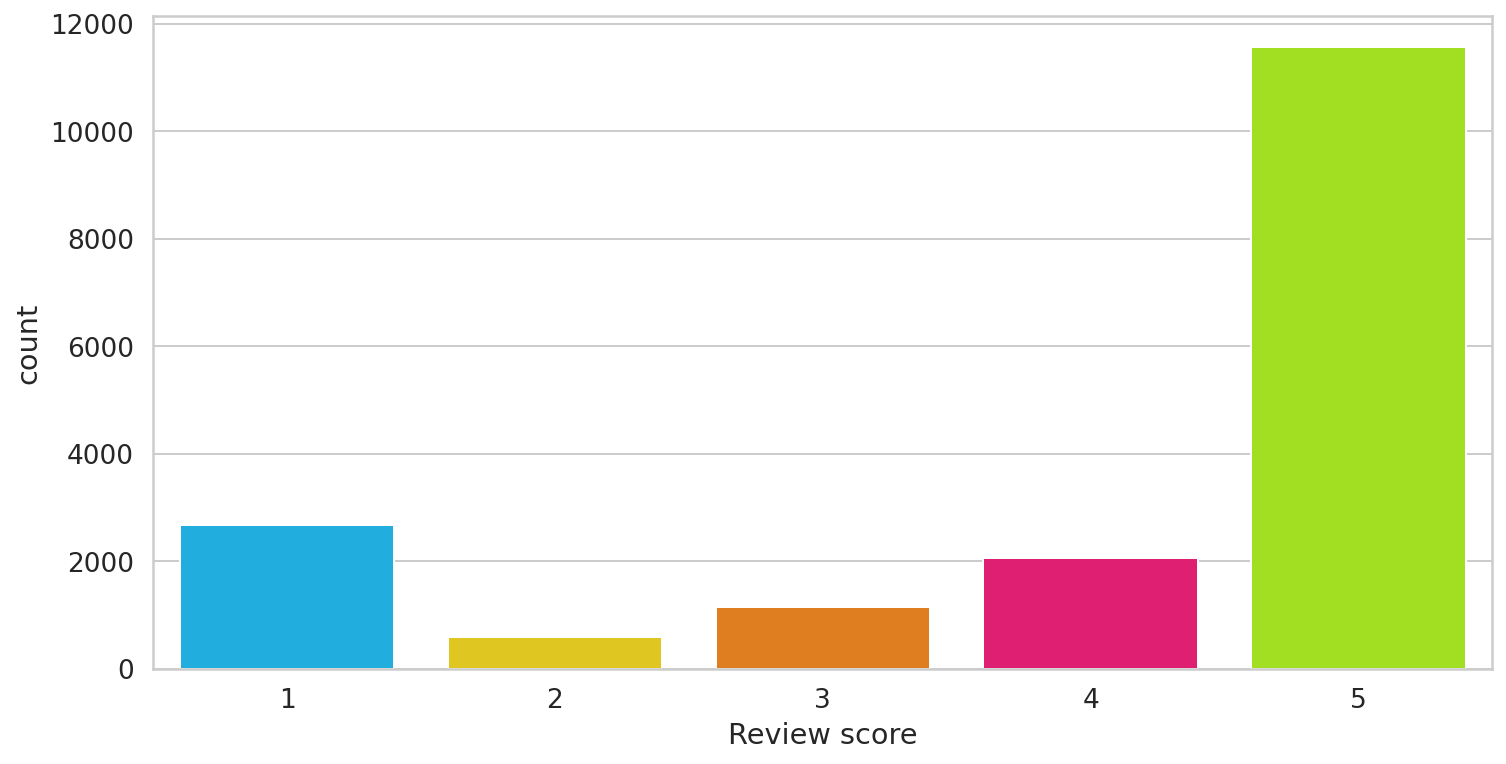

In [ ]:
sns.countplot(df.score)
plt.xlabel('Review score')

We have highly class imbalanced data. Most of the reviews have score 5 in the dataset.

### Let's convert our reviews into Positive & Negative sentiment.

In [ ]:
def to_sentiment(score):
  score=int(score)
  if score <=4:
    return 0
  else :
    return 1

df['sentiment']=df.score.apply(to_sentiment)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOE2Yr0uRwtSM19o3qq9rmIciKMII4oWvQ4X-TV...,Pankaj meena,https://lh3.googleusercontent.com/a-/AOh14GiBW...,wow,5,0,NaN,2020-08-10 03:15:48,NaN,NaN,newest,0,1
1,gp:AOqpTOEyZPR2_epCDBjuEGkFxMN8Uz7uqe8vju5pDDW...,Jesna sinaan Sinaan,https://lh3.googleusercontent.com/-KFcL-CA2eWY...,Super,5,0,NaN,2020-08-10 03:15:47,NaN,NaN,newest,0,1
2,gp:AOqpTOGTrphID0mo58x978-3DDrGXp_oilgqTtrkHvO...,Manoj Verma,https://lh3.googleusercontent.com/-wi1U7m9JVYU...,Majna verna,5,0,NaN,2020-08-10 03:15:44,NaN,NaN,newest,0,1
3,gp:AOqpTOH-6Qcb54ZFIl4MJon9dFtQHjHpLbSTFmw92P8...,MUKESH KUMAR DHRUW,https://lh3.googleusercontent.com/-nEokiW8fSXA...,Nice app,5,0,NaN,2020-08-10 03:14:51,NaN,NaN,newest,0,1
4,gp:AOqpTOGX6kF5IAfLaY_ZxwA7PvPwyxONwGN24JM0jrx...,Ananya Adak,https://lh3.googleusercontent.com/a-/AOh14Gi5w...,Nice,5,0,2.7.3.156,2020-08-10 03:14:42,NaN,NaN,newest,0,1


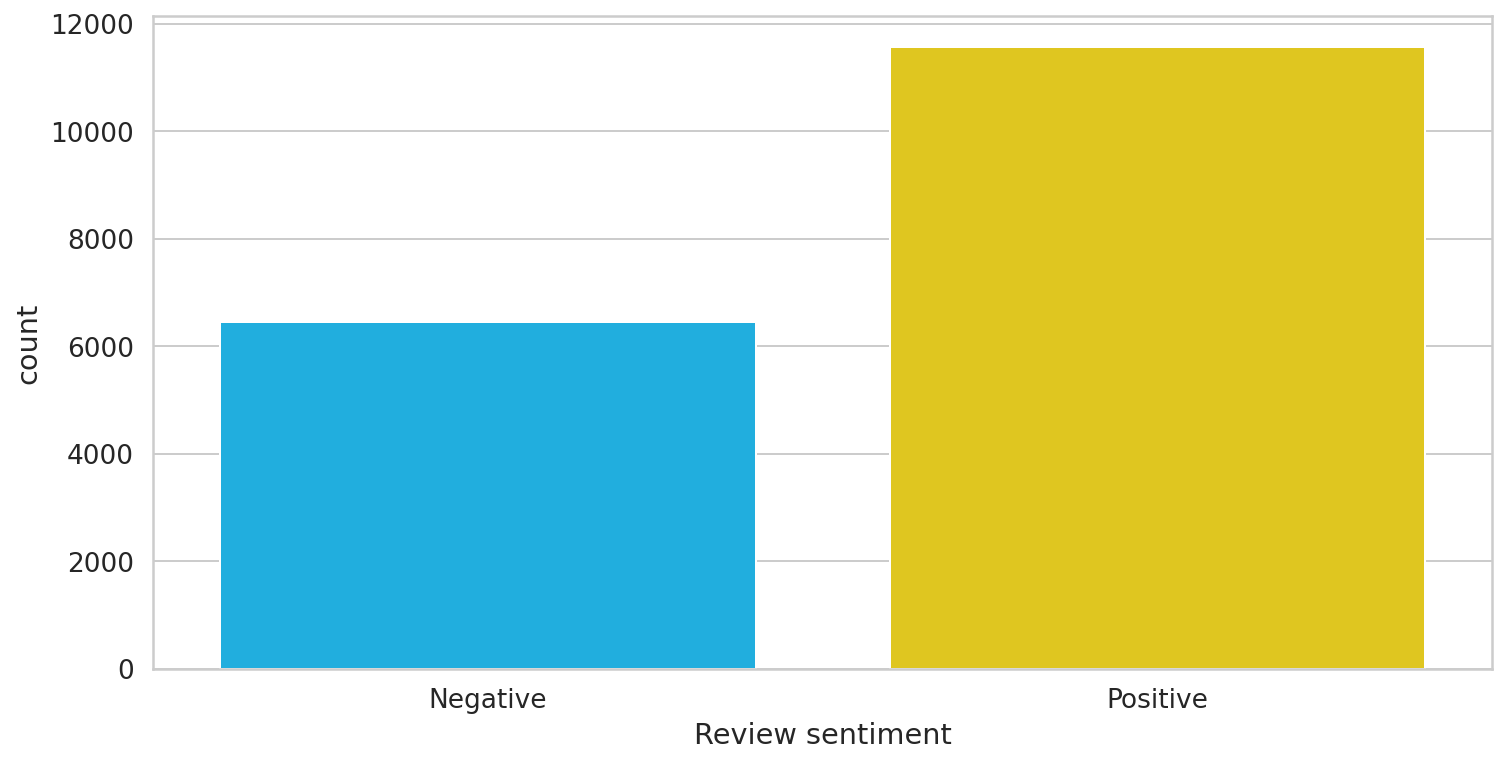

In [ ]:
ax=sns.countplot(df.sentiment)
plt.xlabel('Review sentiment')
class_names=['Negative','Positive']
ax.set_xticklabels(class_names)
plt.show()

Still classes are not balanced. Will proceed anyway..

## **Data Processing**

BERT do not process the raw text & it needs to be converted to numbers by tokenization.

#### Let's tokenize the text data

In [ ]:
Pre_trained_model='bert-base-uncased'

Let's load a pre-trained [BertTokenizerFast]('https://huggingface.co/transformers/model_doc/bert.html#transformers.BertTokenizerFast'):

In [ ]:
tokenizer=BertTokenizerFast.from_pretrained(Pre_trained_model)

Will use a sample text to understand tokenization process:

In [ ]:
sample_text="The animal didn't cross the street because it was too tired"

#Convert text to tokens & token_ids
tokens=tokenizer.tokenize(sample_text)
token_ids=tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence : {sample_text}')
print(f'Tokens :{tokens}')
print(f'Token IDs : {token_ids}')

Sentence : The animal didn't cross the street because it was too tired
Tokens :['the', 'animal', 'didn', "'", 't', 'cross', 'the', 'street', 'because', 'it', 'was', 'too', 'tired']
Token IDs : [1996, 4111, 2134, 1005, 1056, 2892, 1996, 2395, 2138, 2009, 2001, 2205, 5458]


### **Now add Special tokens**

Bert expects  special tokens for each sentence,               
[SEP] - marker for ending of the sentence        
[CLS] - marker for start of each sentence for sentence classification            
[PAD] - marker for padding sentence to a specific length                    
and everything else encodes as             
[UNK] - marker for all tokens expect tokens in trained data.

In [ ]:
encoding=tokenizer.encode_plus(
    sample_text,
    max_length=32,
    add_special_tokens=True,   # 'Add [SEP] & [CLS]'
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,  # Reurns array of 0's & 1's to distinguish padded tokens from real tokens.
    return_token_type_ids=False,
    return_tensors='pt'         # Returns pytorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

Encoding contains input_ids & attention masks of same length 32 for each sentence.

In [ ]:
# Check input_ids
print('Maximum length of input_ids for each sentence : {}'.format(len(encoding['input_ids'][0])))
encoding['input_ids'][0]

Maximum length of input_ids for each sentence : 32


tensor([ 101, 1996, 4111, 2134, 1005, 1056, 2892, 1996, 2395, 2138, 2009, 2001,
        2205, 5458,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:

#check attention mask
print(f"Maximum length of attention mask for each sentence : {len(encoding['attention_mask'][0])}")
encoding['attention_mask'][0]

Maximum length of attention mask for each sentence : 32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

#### Let's convert token_ids to tokens to look at special tokens

In [ ]:
special_tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
special_tokens

['[CLS]',
 'the',
 'animal',
 'didn',
 "'",
 't',
 'cross',
 'the',
 'street',
 'because',
 'it',
 'was',
 'too',
 'tired',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### **Choosing Sequence length for our dataset**

#### Let's store the token length of each review

In [ ]:
token_lens=[]
for content in df.content:
  tokens_content=tokenizer.encode(content,max_length=150,truncation=True)
  token_lens.append(len(tokens_content))

Text(0.5, 0, 'Token count')

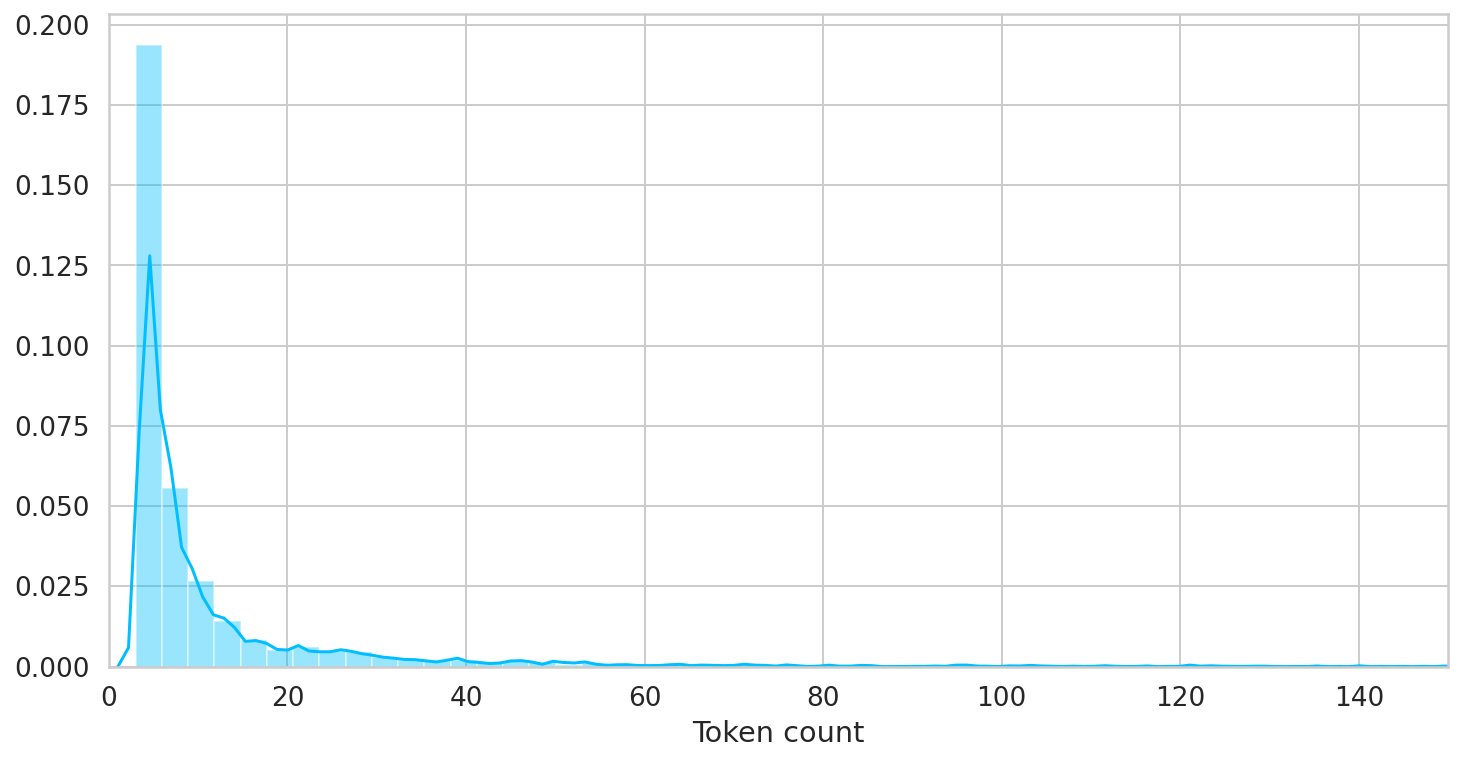

In [ ]:
#Plot the tokens
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

It appears that the length of most tokens lies between 3 & 30. On safer side, we are taking maximum sequence length of 100.

In [ ]:
Max_length=100

Now let's create a **Pytorch dataset**

Pytorch dataset is of map-style i.e., it implements __getitem__  &  __len__  protocols, & represents a map from indices/keys to datasamples.

In [ ]:
class reviews_India_Dataset(Dataset):

  def __init__(self,reviews,targets,tokenizer,max_length):
    self.reviews=reviews
    self.targets=targets
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self,item):
    review = str(self.reviews[item])
    targets = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review,
        max_length=Max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
    return {
        'review_text':review,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(targets,dtype=torch.long)
    }

### **Let's split the data**

In [ ]:
df_train,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_valid,df_test = train_test_split(df_test,test_size=0.5,random_state=42)

print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape}')
print(f'Testing dataset : {df_test.shape}')
print(f'Validation dataset : {df_valid.shape}')

Print the shape of datasets...
Training dataset : (14400, 13)
Testing dataset : (1800, 13)
Validation dataset : (1800, 13)


#### Now will create a helper function for **Data loader**

In [ ]:
batch_size=32
def data_loader(df, tokenizer, max_length, batch):
  ds=reviews_India_Dataset(
      reviews=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# Load datasets
train_DataLoader=data_loader(df_train,tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(df_test,tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_valid,tokenizer,Max_length,batch_size)

#### Let's have a look at example batch from **training DataLoader**

In [ ]:
data=next(iter(train_DataLoader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print('Shape of the data keys...')
print(f"Input_ids : {data['input_ids'].shape}")
print(f"Attention_mask : {data['attention_mask'].shape}")
print(f"targets : {data['targets'].shape}")

Shape of the data keys...
Input_ids : torch.Size([32, 100])
Attention_mask : torch.Size([32, 100])
targets : torch.Size([32])


## Let's build a Sentiment Classifier

#### Let's load the basic BERT model

In [ ]:
bert_model = BertModel.from_pretrained(Pre_trained_model)

Now create a classifier that uses BERT model

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(Pre_trained_model)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

The **pooled_output** is a summary of the content, according to BERT & it is obtained by applying **BertPooler** on **last_hidden_state.**      
We are using a **dropout layer** for some regularization and a **fully-connected layer** for our output.

### Let’s create an instance and move it to the GPU

In [ ]:
model = SentimentClassifier(len(class_names))         #Create an instance / object
model = model.to(device)                              # Move instance to GPU           

Now move the  batch training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 100])
torch.Size([32, 100])


Apply softmax function to outputs to get the predicted probabilities from our trained model.

In [ ]:
 F.softmax(model(input_ids,attention_mask), dim=1)

tensor([[0.5007, 0.4993],
        [0.5157, 0.4843],
        [0.5978, 0.4022],
        [0.6417, 0.3583],
        [0.3159, 0.6841],
        [0.6252, 0.3748],
        [0.3908, 0.6092],
        [0.7216, 0.2784],
        [0.4637, 0.5363],
        [0.6088, 0.3912],
        [0.5829, 0.4171],
        [0.6474, 0.3526],
        [0.4393, 0.5607],
        [0.4355, 0.5645],
        [0.5535, 0.4465],
        [0.6584, 0.3416],
        [0.4583, 0.5417],
        [0.5741, 0.4259],
        [0.4362, 0.5638],
        [0.5383, 0.4617],
        [0.6587, 0.3413],
        [0.4157, 0.5843],
        [0.5362, 0.4638],
        [0.4192, 0.5808],
        [0.4842, 0.5158],
        [0.5078, 0.4922],
        [0.6332, 0.3668],
        [0.8156, 0.1844],
        [0.5684, 0.4316],
        [0.5828, 0.4172],
        [0.4275, 0.5725],
        [0.5687, 0.4313]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Let's train our sentiment classifier

As per original paper on BERT, we will use [AdamW]('https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw') optimizer for correcting weight decay. We will also use, linear scheduler with no warm up steps:

In [ ]:
epochs=5
optimizer=AdamW(model.parameters(),lr=2e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

Now write a helper function to train our model:

In [ ]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    #Feed data to BERT model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_observations, np.mean(losses)

Similarly, write a helper function to evaluate our model:

In [ ]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      # Feed data to BERT model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_observations, np.mean(losses)

Using above helper functions, write our training loop & store training history:

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)
  train_acc, train_loss = train(
    model,
    train_DataLoader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    valid_DataLoader,
    device,
    loss_fn,
    len(df_valid)
  )
  print(f'Validation  loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.47611681451400123 accuracy 0.7898611111111111
Validation  loss 0.3784769187893784 accuracy 0.8505555555555555

Epoch 2/5
----------
Train loss 0.3186262480252319 accuracy 0.8739583333333333
Validation  loss 0.36791067805729416 accuracy 0.8633333333333333

Epoch 3/5
----------
Train loss 0.27169653023282686 accuracy 0.8897916666666666
Validation  loss 0.36155224486924054 accuracy 0.8744444444444445

Epoch 4/5
----------
Train loss 0.24348440777924327 accuracy 0.8986805555555556
Validation  loss 0.37006600893903197 accuracy 0.8722222222222222

Epoch 5/5
----------
Train loss 0.23166723863946068 accuracy 0.9036111111111111
Validation  loss 0.3703288694745616 accuracy 0.8783333333333333

CPU times: user 16min 13s, sys: 8min 36s, total: 24min 50s
Wall time: 25min 4s


We got 87.88 % validation accuracy for 5 epochs, not bad.The number of epochs 
can be increased to get higher validation accuracy.


Let's look at training vs validation accuracy:

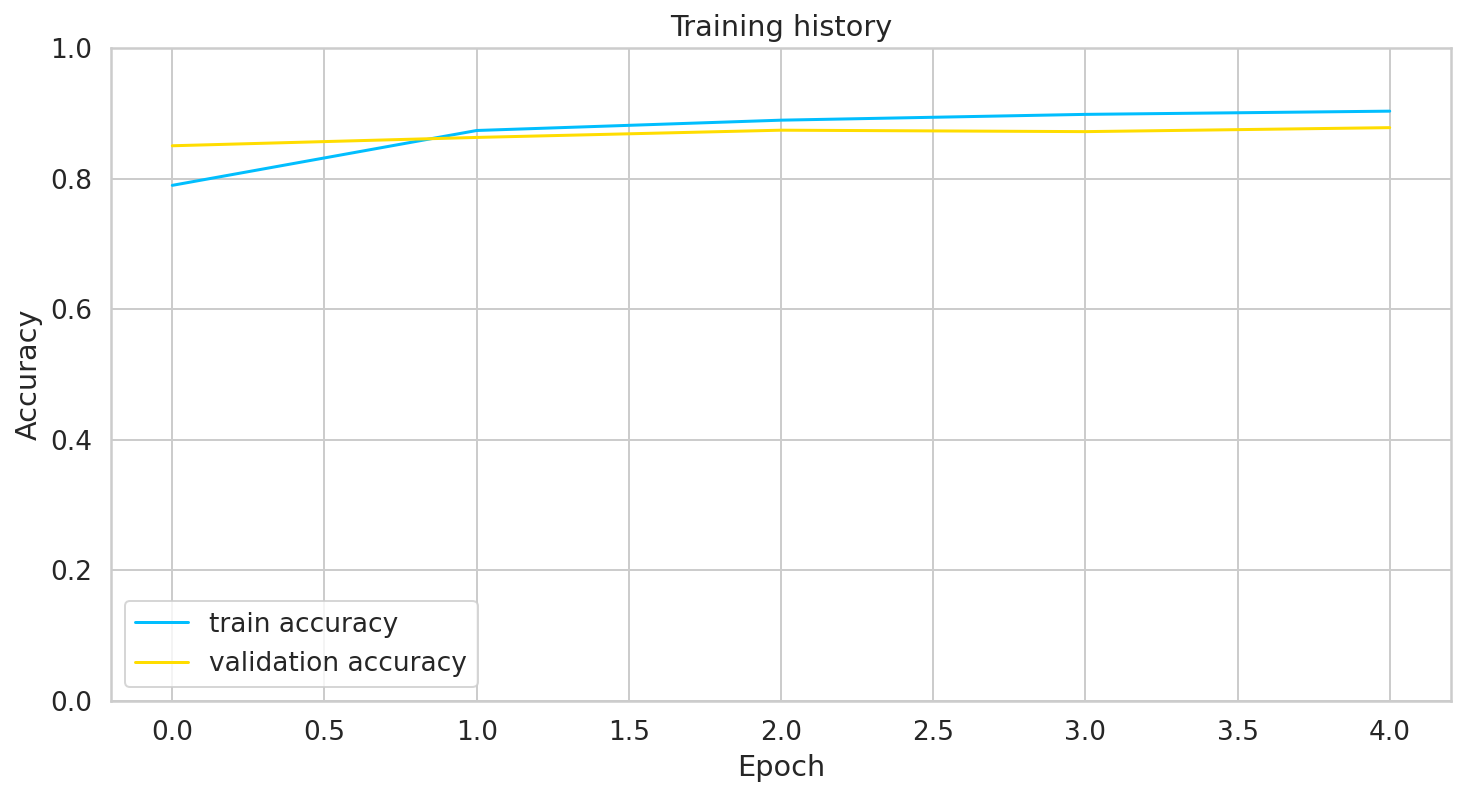

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Model Evaluation

Let's see how good our model on unseen data.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_DataLoader,
  device,
  loss_fn,
  len(df_test)
)

In [ ]:
test_acc.item()

0.8794444444444445

That is model performing well on test data, we are getting 88.33% accuracy which is 0.45% more than validation accuracy. It seems model is generalizing well.

Now we will write helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_DataLoader
)

Let's have a look at the classification report:

In [ ]:
class_report=classification_report(y_test, y_pred, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

    Negative       0.93      0.72      0.81       645
    Positive       0.86      0.97      0.91      1155

    accuracy                           0.88      1800
   macro avg       0.89      0.84      0.86      1800
weighted avg       0.88      0.88      0.88      1800



We are getting f1-score=0.88, not bad. This model can be fine tuned further to get high f1-scores.

Now will plot confusion matrix:

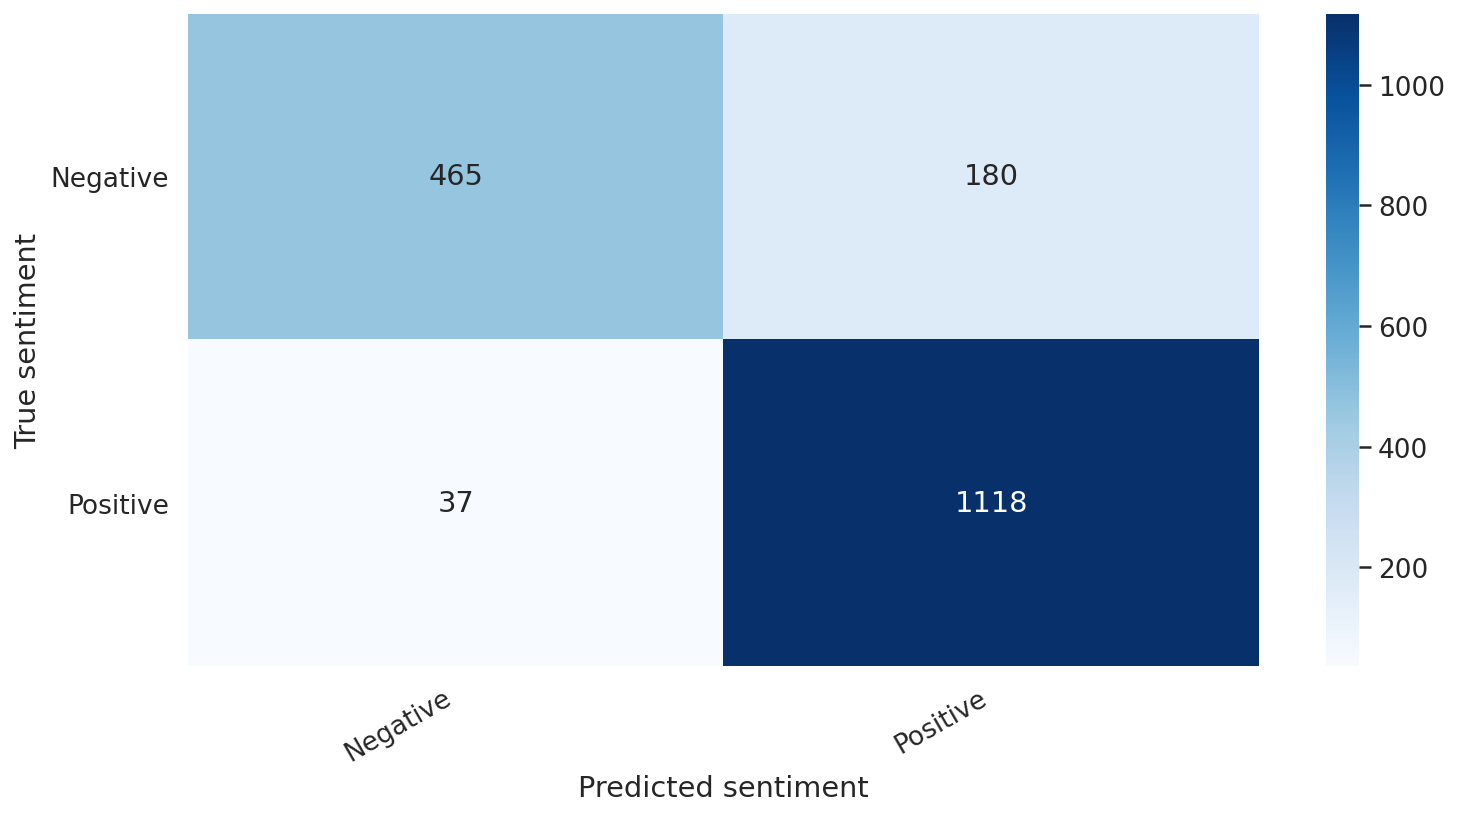

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms our model having difficulty in classifying negative reviews. This is because the classes were imbalanced i.e., the number of positive classes more than negative. This imbalanced data made model biased towards positive class, so it is not classifying negative reviews correctly. This can be avoided with balanced data & also classes can be balanced using sampling methods such as SMOTE.

### Plot PR (Precesion-Recall) curve

PR curve is an intuitive measure when evaluating binary classifiers on imbalanced datasets. Since the classes are imbalanced in our data, we are using PR curve as a metric for model evaluation.

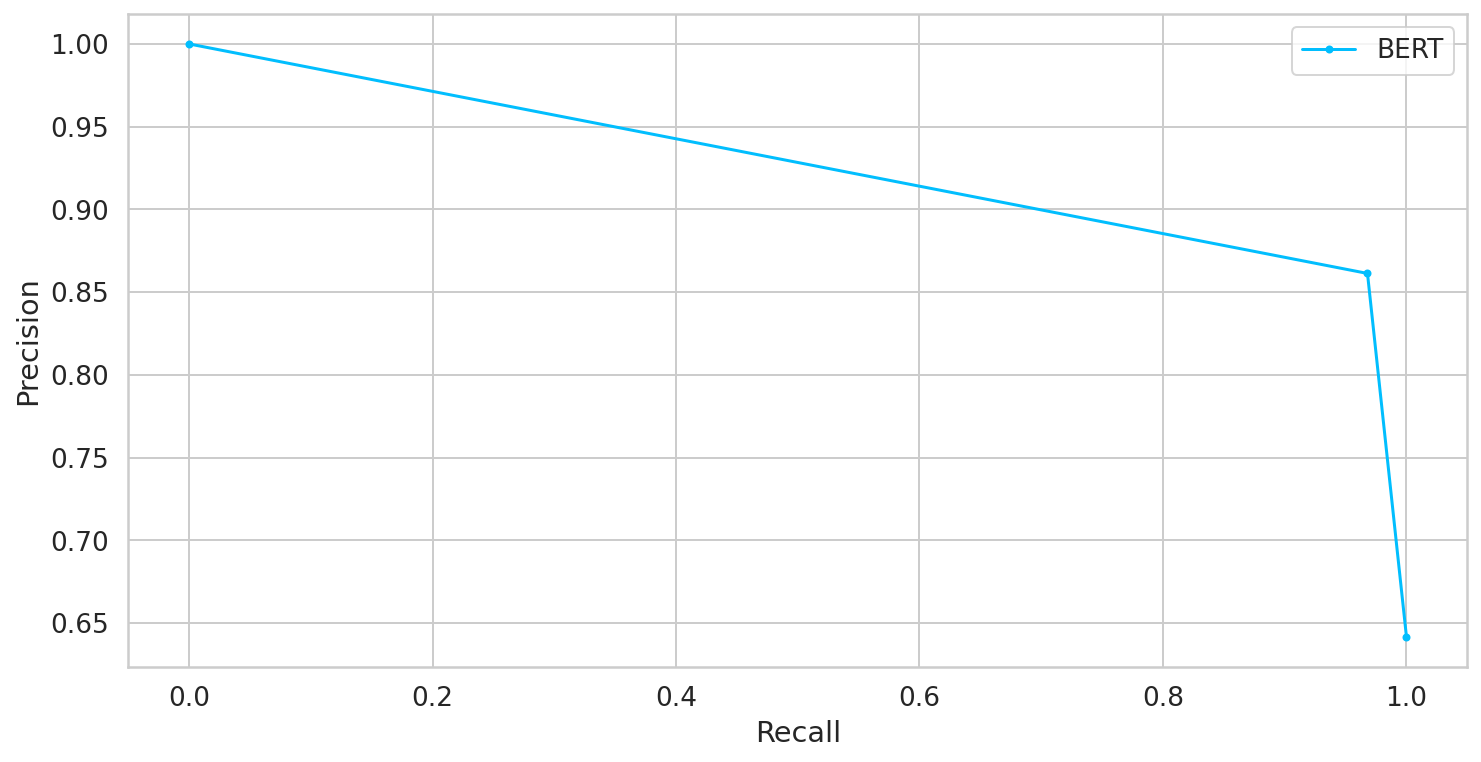

In [ ]:
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='BERT')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
#Calculate AUC_score for PR curve
auc_score = auc(recall, precision)
print('PR AUC_score: %.3f' % auc_score)

PR AUC_score: 0.925


We are getting Area under the curve (AUC) for precision-recall curve is 0.927, this is good enough for model to generalize well on unseen imbalanced dataset.

Now let's have a look at an example from our test data:

In [ ]:
review_text=y_review_texts[1]
true_sentiment=y_test[1]
pred_df=pd.DataFrame({
    'class_names':class_names,
    'values':y_pred_probs[1]
})

print('\n'.join(wrap(review_text)))
print()
print(f'True Sentiment : {class_names[true_sentiment]}')

best chatting app in the world.....my all time favourite app i am in
love with telegram just awesome app thanks to the all developer to
develop app and latest features.

True Sentiment : Positive


Now we look at the confidence of each sentiemt of our model:

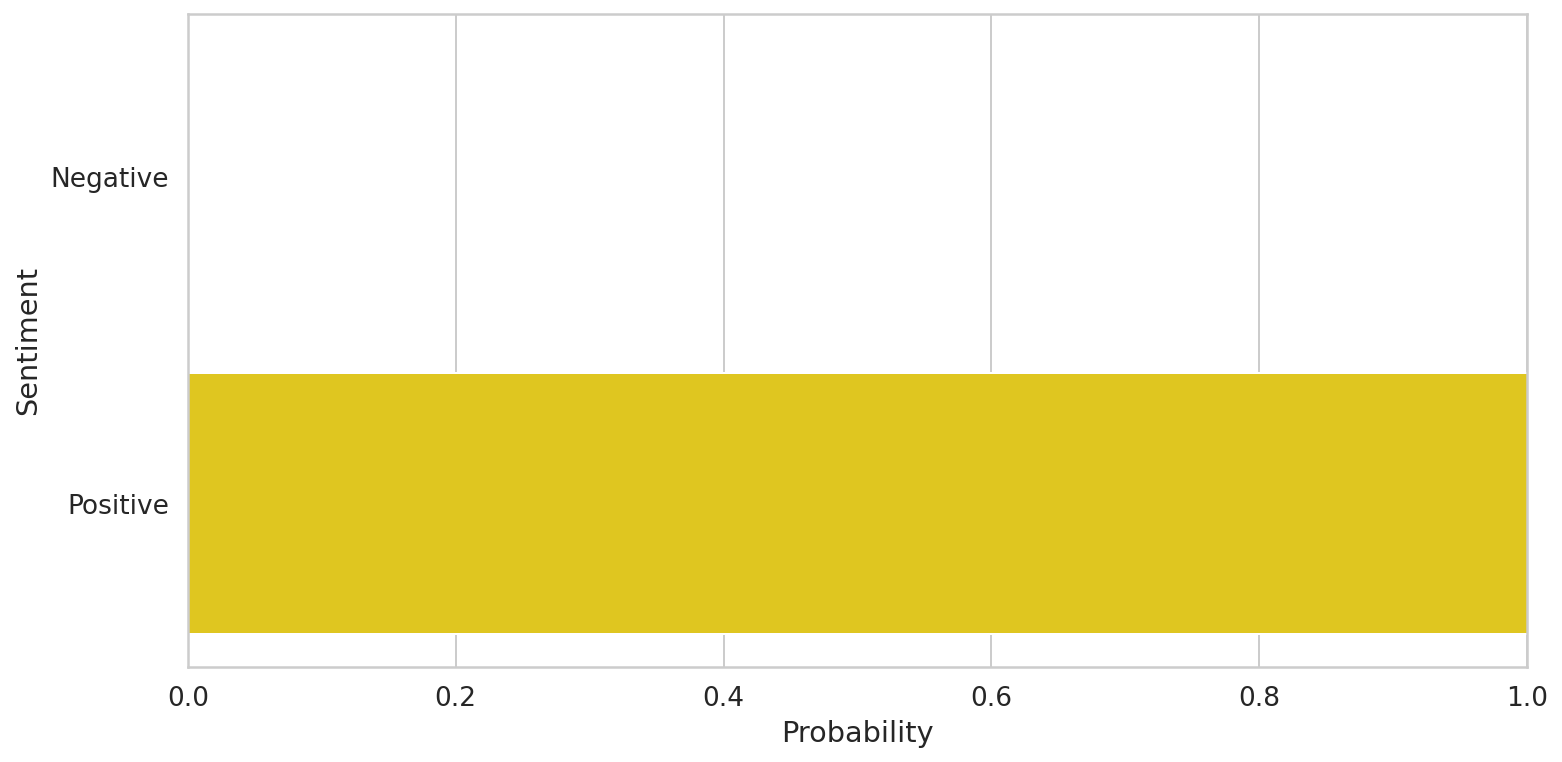

In [ ]:
sns.barplot(x='values',y='class_names',data=pred_df,orient='h')
plt.xlabel('Probability')
plt.ylabel('Sentiment')
plt.xlim([0,1]);

## Predicting on Raw text

Let's us use our model to predict sentiment on raw text:

In [ ]:
review_text='Fake Fake Fake Fake Fake, Please be aware of them, they are very dangerous people please be aware of them. \
They ask your pan and aadhara number for interview, the ppl who calls are unprofessional they talk rubbish and try to trap you in pit'

Now use the tokenizer to encode the raw text:

In [ ]:
encoded_review=tokenizer.encode_plus(
    review_text,
    max_length=Max_length,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

Let's get predictions from our model:

In [ ]:
input_ids=encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)

output=model(input_ids,attention_mask)
_,pred=torch.max(output,dim=1)

print(f'Review_text : {review_text}')
print(f'Sentiment: {class_names[pred]}')

Review_text : Fake Fake Fake Fake Fake, Please be aware of them, they are very dangerous people please be aware of them. They ask your pan and aadhara number for interview, the ppl who calls are unprofessional they talk rubbish and try to trap you in pit
Sentiment: Negative


Wow, our model is generalizing well. This model can be fine tuned further to improve its performance.

## Save our model in Google drive


In [ ]:
path="/content/drive/My Drive/Colab Notebooks/Models/Sentiment_Analysis_Bert.bin"
torch.save(model.state_dict(),path)

## References:

* [Sentiment analysis with BERT](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/#data-preprocessing)
* [ROC & PR curves for imbalanced datasets](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
* [Evaluation Metrics, ROC-Curves and imbalanced datasets](http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/#:~:text=The%20curve%20is%20a%20plot,false%20positives%20and%20false%20negatives.)